# DAS Denoising - Application to Otway Microseismic Data
Apply trained models to Otway microseismic events.

Notebook steps: 
- [Load Packages and Scripts](#load_packages)
- [Set Display and Export Parameters](#set_param)
- [Load Data](#load_data)
- [Load Model](#load_model)
- [Preprocess Data](#data_preprocessing)
- [Run Model](#run_model)
- [Compute Signal to Noise Ratio](#compute_SNR)
- [Plot Figures SL Denoising](#plot_fig_SL)
- [Plot Figures N2N Denoising](#plot_fig_N2N)

<a id=load_packages></a>
## Load Packages and Scripts

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [2]:
import tensorflow as tf
from tensorflow.keras.models import *
# Tensorflow version
print('TensorFlow version:',tf.__version__)
# Set gpu memory if gpu is available
gpu = tf.config.list_physical_devices('GPU') # Check GPU available
print(gpu)
if gpu: 
    tf.config.experimental.set_memory_growth(gpu[0], True)

TensorFlow version: 2.10.1
[]


Import functions for data loading and signal to noise computations

In [35]:
# Import local scripts
from Utils.RP_Proc import fCalcFrameSNR, fCalcSNR2DFrame, fRingdownRemoval, fOrmsbyBPFilter
from Utils.string_manip import find_str_between
from Utils.apply_nn import fDenoiseDAS
from Utils.DAS_raw import fLoadSilixaTDMS

<a id=set_param></a>
## Set Display, Input Data and Model Paths

In [4]:
# Input data
data_path = r'Data\Otway'
tdms_files = [os.path.join(data_path,x) for x in os.listdir(data_path) if '.tdms' in x]
tdms_files;

In [5]:
# Plot parameters
plt.rc('axes',labelsize=14)
plt.rc('font',size=14)
plt.rc('xtick',labelsize='medium')
plt.rc('ytick',labelsize='medium')
plt.rc('grid', linestyle=':', linewidth=0.5)
interpolation_opt = 'sinc'
c_map = 'seismic'
v_max = 15

In [6]:
# Optional pre-processing steps
apply_detrend = True
apply_ringDownRemoval = True

In [7]:
# Input models
model_NGL_N2N = 'Models\\N2N_LowPowerSourceTest_30ep_v10_patch128x96_dgtarget_fliplr.h5'
model_trad = 'Models\\Supervised_Otway_100Shots_250Epochs0.8_3_Nnet4.h5'
model_FCDNet = 'Models\\Unit100Shots200Epochs0.8_3_FCDnet.h5'

<a id=load_data></a>
## Load Data

In [8]:
# Load data
D, dx, mlength, dt = fLoadSilixaTDMS(tdms_files[0])
# Check size
np.shape(D)

(30000, 3456)

In [9]:
dt

0.001

Channel selection:

In [10]:
ch_range = [105,1680]; #CRC7
ch_start = ch_range[0]
ch_end = ch_range[1] 
# Define time range from event
ti_start = 2000
ti_end = 10000
D = D[ti_start:ti_end,ch_start:ch_end];
if apply_detrend:
    D = signal.detrend(D,axis=0)
if apply_ringDownRemoval:
    D = fRingdownRemoval(D)
D.shape

(8000, 1575)

<a id=load_model></a>
## Load Model

In [11]:
dasn2n = load_model(model_NGL_N2N) # DAS-N2N
trad = load_model(model_trad) #taditional supervised
FCDNet = load_model(model_FCDNet) # FCDNet

<a id=data_preprocessing></a>
## Pre-Processing Steps

In [12]:
#-- Optional trend and median removal
if apply_detrend:
    D = signal.detrend(D,axis=0)
if apply_ringDownRemoval:
    D = fRingdownRemoval(D)

<a id=run_model></a>
## Apply Denoising

N2N network

In [13]:
%%time
st_array_out = fDenoiseDAS(D, dasn2n, 
                           apply_detrend=apply_detrend, apply_ringDownRemoval=apply_ringDownRemoval)

Extracting 4125 patches
wHann_submatrices[128, 96]
(1, 8064, 1632)
CPU times: total: 3min 54s
Wall time: 34.5 s


Traditional supervised learning

In [14]:
st_array_out_trad = fDenoiseDAS(D, trad, 
                           apply_detrend=apply_detrend, apply_ringDownRemoval=apply_ringDownRemoval)

Extracting 4125 patches
wHann_submatrices[128, 96]
(1, 8064, 1632)


FCDNet

In [15]:
st_array_out_FCDNet = fDenoiseDAS(D, FCDNet, 
                           apply_detrend=apply_detrend, apply_ringDownRemoval=apply_ringDownRemoval)

Extracting 3125 patches
wHann_submatrices[128, 128]
(1, 8064, 1664)


Bandpass filtering

In [16]:
f1=1
f2=5
f3=100
f4=200
st_array_out_BP = fOrmsbyBPFilter(D,dt*1000,f1,f2,f3,f4,1)

Plot comparison

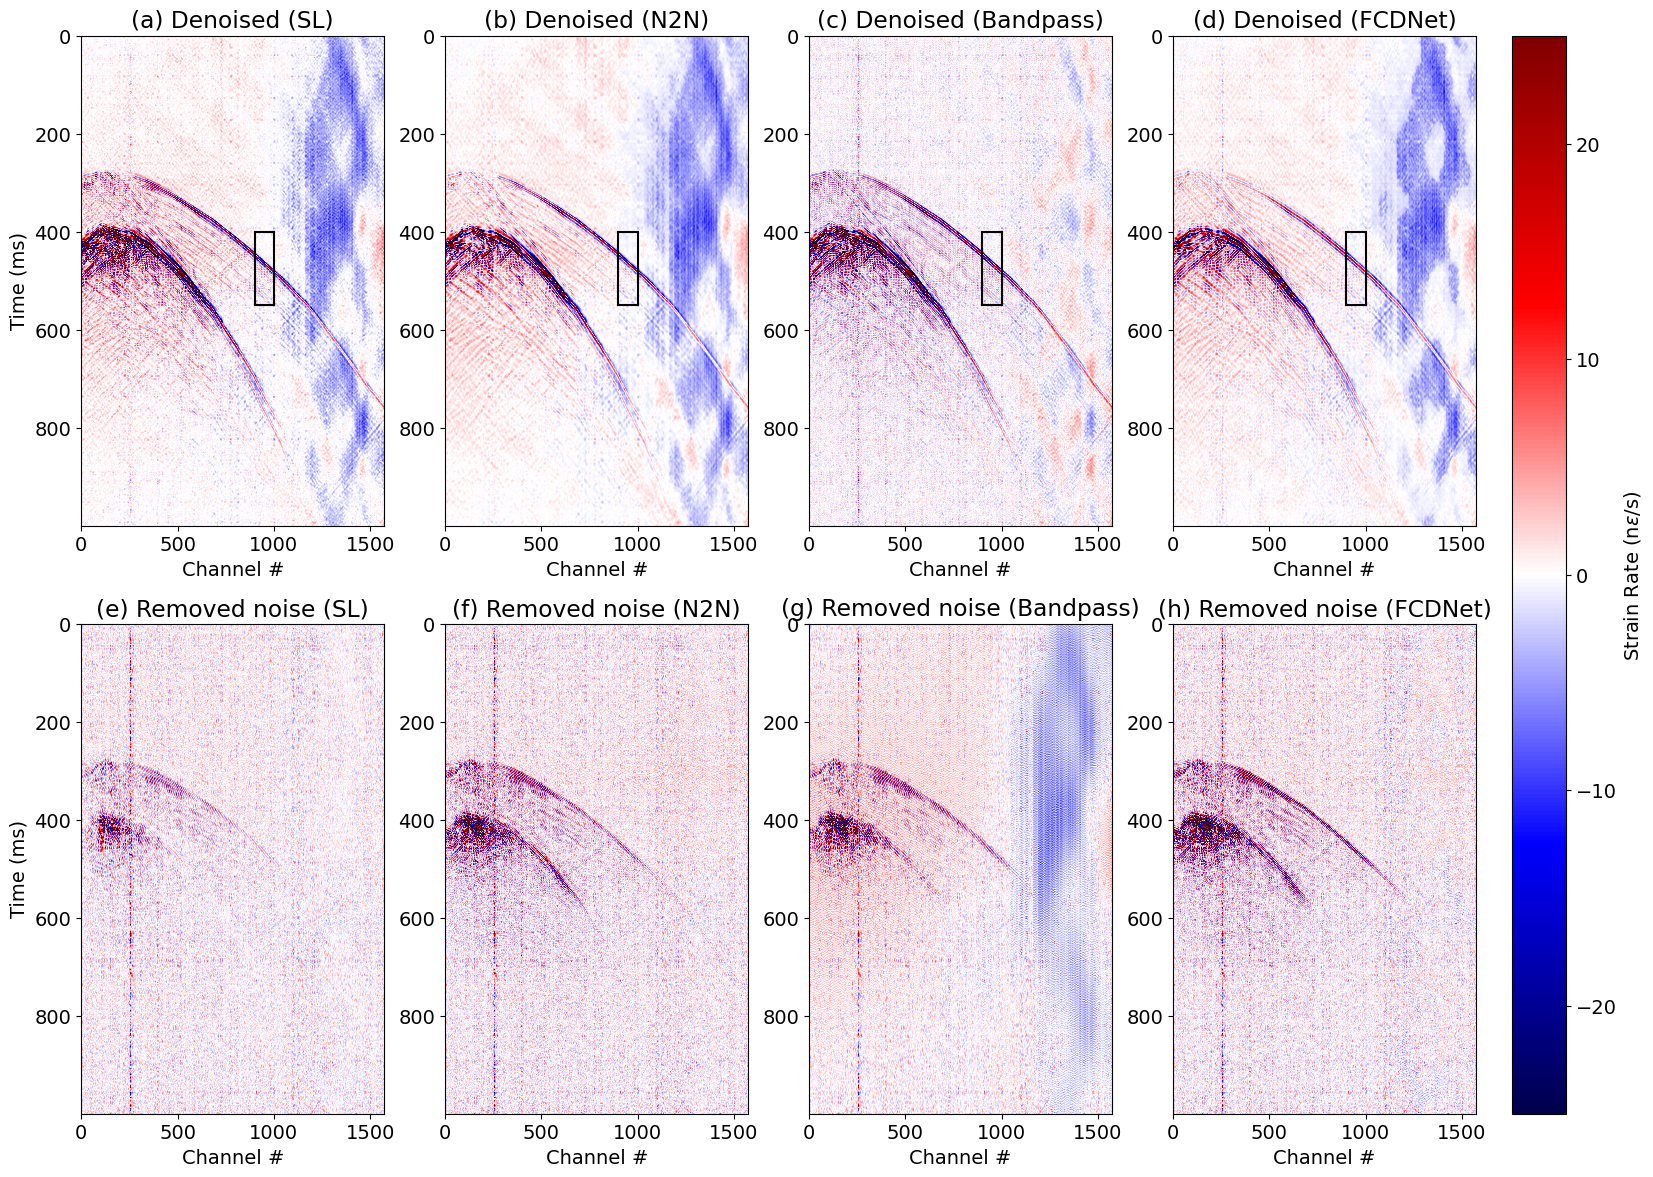

In [17]:
fig, axs = plt.subplots(2,4,figsize=(18,14))
ch_start_display=0
ch_end_display=1575
t_start_display=1800
t_end_display=2800
v_max = 25
plot_zoom = True
#--1st row: denoised results
axs[0,0].imshow(st_array_out_trad[t_start_display:t_end_display,ch_start_display:ch_end_display], interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                vmin=-v_max, vmax=v_max)
axs[0,0].set(title='(a) Denoised (SL)', xlabel='Channel #', ylabel='Time (ms)')
axs[0,1].imshow(st_array_out[t_start_display:t_end_display,ch_start_display:ch_end_display], interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                vmin=-v_max, vmax=v_max)
axs[0,1].set(title='(b) Denoised (N2N)', xlabel='Channel #')
axs[0,2].imshow(st_array_out_BP[t_start_display:t_end_display,ch_start_display:ch_end_display], interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                vmin=-v_max, vmax=v_max)
axs[0,2].set(title='(c) Denoised (Bandpass)', xlabel='Channel #')
axs[0,3].imshow(st_array_out_FCDNet[t_start_display:t_end_display,ch_start_display:ch_end_display], interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                vmin=-v_max, vmax=v_max)
axs[0,3].set(title='(d) Denoised (FCDNet)', xlabel='Channel #')
#--2nd row: removed noise
axs[1,0].imshow(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out_trad[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                    interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                    vmin=-v_max, vmax=v_max)
axs[1,0].set(title='(e) Removed noise (SL)', xlabel='Channel #', ylabel='Time (ms)')
axs[1,1].imshow(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                vmin=-v_max, vmax=v_max)
axs[1,1].set(title='(f) Removed noise (N2N)', xlabel='Channel #')
axs[1,2].imshow(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out_BP[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                  interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                  vmin=-v_max, vmax=v_max)
axs[1,2].set(title='(g) Removed noise (Bandpass)', xlabel='Channel #')
im = axs[1,3].imshow(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out_FCDNet[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                    interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                    vmin=-v_max, vmax=v_max)
axs[1,3].set(title='(h) Removed noise (FCDNet)', xlabel='Channel #')
if plot_zoom:
    ch_start_zoom=900
    ch_end_zoom=1000
    t_start_zoom=2200
    t_end_zoom=2350
    for i in range(0,4):
        axs[0,i].plot([ch_start_zoom,ch_end_zoom],[t_start_zoom-t_start_display,t_start_zoom-t_start_display], 'k')
        axs[0,i].plot([ch_start_zoom,ch_end_zoom],[t_end_zoom-t_start_display,t_end_zoom-t_start_display], 'k')
        axs[0,i].plot([ch_start_zoom,ch_start_zoom],[t_start_zoom-t_start_display,t_end_zoom-t_start_display], 'k')
        axs[0,i].plot([ch_end_zoom,ch_end_zoom],[t_start_zoom-t_start_display,t_end_zoom-t_start_display], 'k')   
# Add single colorbar to the right
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax, label='Strain Rate (n$\epsilon$/s)')
plt.show()    

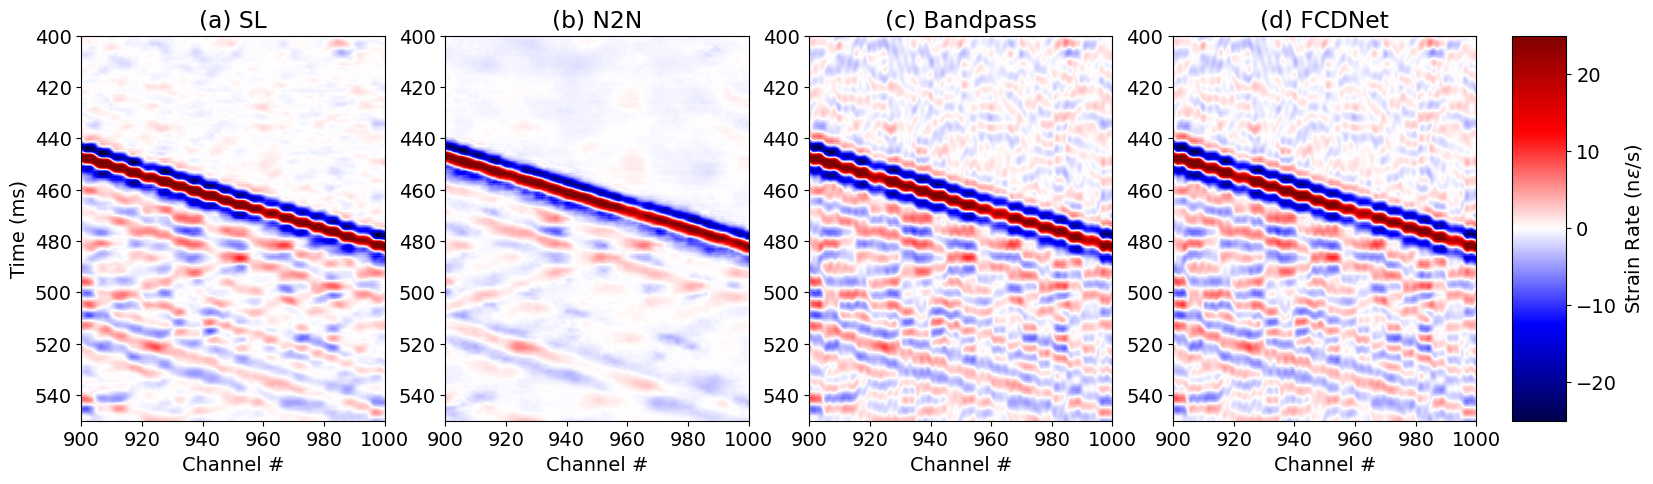

In [18]:
fig, axs = plt.subplots(1,4,figsize=(18,5))
ch_start_zoom=900
ch_end_zoom=1000
t_start_zoom=2200
t_end_zoom=2350
extent = [ch_start_zoom-ch_start_display, ch_end_zoom-ch_start_display, 
          t_end_zoom-t_start_display, t_start_zoom-t_start_display]
axs[0].imshow(st_array_out_trad[t_start_zoom:t_end_zoom,ch_start_zoom:ch_end_zoom], 
              interpolation=interpolation_opt, aspect='auto', cmap=c_map,
              vmin=-v_max, vmax=v_max, extent=extent)
axs[0].set(title='(a) SL', xlabel='Channel #', ylabel='Time (ms)')
axs[1].imshow(st_array_out[t_start_zoom:t_end_zoom,ch_start_zoom:ch_end_zoom], 
              interpolation=interpolation_opt, aspect='auto', cmap=c_map,
              vmin=-v_max, vmax=v_max, extent=extent)
axs[1].set(title='(b) N2N', xlabel='Channel #')
axs[2].imshow(st_array_out_BP[t_start_zoom:t_end_zoom,ch_start_zoom:ch_end_zoom], 
              interpolation=interpolation_opt, aspect='auto', cmap=c_map,
              vmin=-v_max, vmax=v_max, extent=extent)
axs[2].set(title='(c) Bandpass', xlabel='Channel #')
im = axs[3].imshow(st_array_out_BP[t_start_zoom:t_end_zoom,ch_start_zoom:ch_end_zoom], 
              interpolation=interpolation_opt, aspect='auto', cmap=c_map,
              vmin=-v_max, vmax=v_max, extent=extent)
axs[3].set(title='(d) FCDNet', xlabel='Channel #')
# Add single colorbar to the right
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax, label='Strain Rate (n$\epsilon$/s)')
# plt.suptitle(plt_title, weight='bold')
plt.show()

<a id=compute_SNR></a>
## Compute Signal to Noise Ratio

SNR frame values

In [21]:
maxlag = 0.1 #(in s)
percent = 30;
ch_start_display = 0
snr_frame_in = fCalcFrameSNR(D[t_start_display:t_end_display,ch_start_display:ch_end_display],percent,np.ceil(maxlag/dt).astype(int))
#--N2N results
snr_frame_out_N2N = fCalcFrameSNR(st_array_out[t_start_display:t_end_display,ch_start_display:ch_end_display],percent,np.ceil(maxlag/dt).astype(int))
snr_frame_noise_N2N = fCalcFrameSNR(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out[t_start_display:t_end_display,ch_start_display:ch_end_display],
                                    percent,np.ceil(maxlag/dt).astype(int))
#--SL results
snr_frame_out_trad = fCalcFrameSNR(st_array_out_trad[t_start_display:t_end_display,ch_start_display:ch_end_display],percent,np.ceil(maxlag/dt).astype(int))
snr_frame_noise_trad = fCalcFrameSNR(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out_trad[t_start_display:t_end_display,ch_start_display:ch_end_display],
                                    percent,np.ceil(maxlag/dt).astype(int))

In [22]:
print('SNR in:', snr_frame_in)
print('SNR N2N:', snr_frame_out_N2N, snr_frame_noise_N2N)
print('SNR SL:', snr_frame_out_trad, snr_frame_noise_trad)

SNR in: 2.651688136880204
SNR N2N: 7.735312509930921 2.1293042528157984
SNR SL: 7.510421080144662 2.02883299057636


SNR sections

In [23]:
%%time
window = 30
snr_in = fCalcSNR2DFrame(D[t_start_display:t_end_display,ch_start_display:ch_end_display],window)
#--N2N results
snr_out_N2N = fCalcSNR2DFrame(st_array_out[t_start_display:t_end_display,ch_start_display:ch_end_display],window)
snr_noise_N2N = fCalcSNR2DFrame(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out[t_start_display:t_end_display,ch_start_display:ch_end_display],
                                window)
#--SL results
snr_out_trad = fCalcSNR2DFrame(st_array_out_trad[t_start_display:t_end_display,ch_start_display:ch_end_display],window)
snr_noise_trad = fCalcSNR2DFrame(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out_trad[t_start_display:t_end_display,ch_start_display:ch_end_display],
                                 window)

CPU times: total: 30.6 s
Wall time: 30.7 s


<a id=plot_fig_SL></a>
## Plot Figures SL Denoising

In [30]:
plt_fig_paper = True
plot_zoom = False

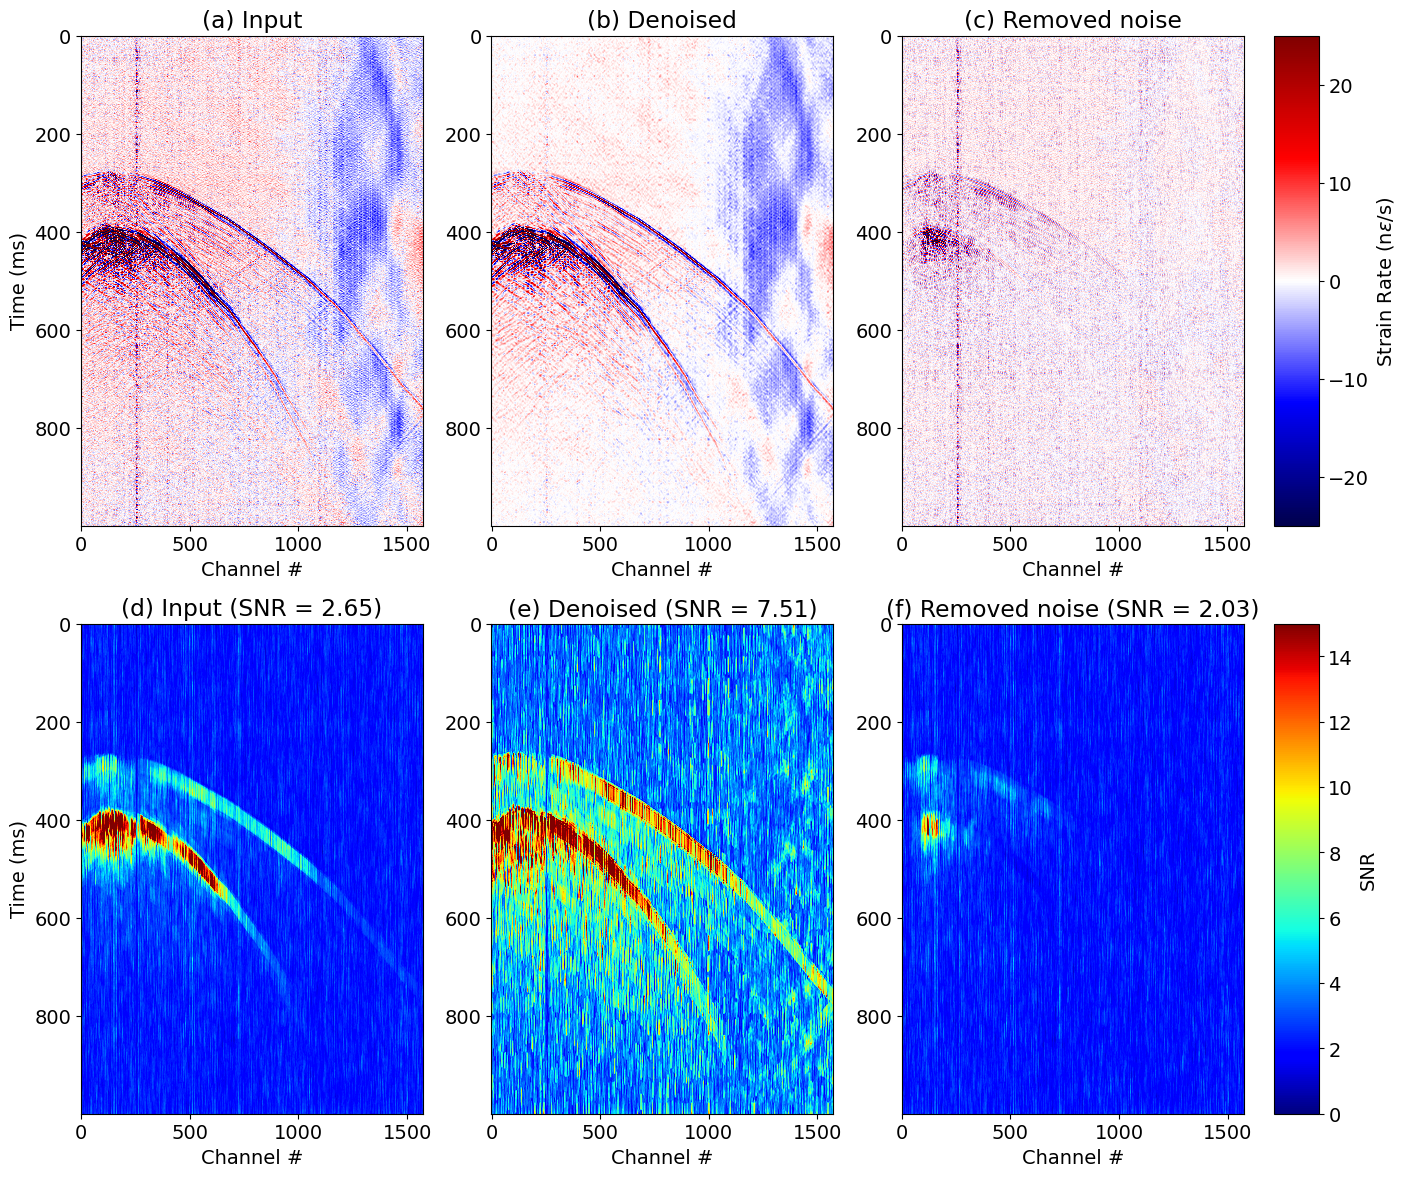

In [29]:
if plt_fig_paper:
    fig, axs = plt.subplots(2,3,figsize=(15,14))
    v_max = 25
    c_map = 'seismic'
    #--1st row: gathers
    axs[0,0].imshow(D[t_start_display:t_end_display,ch_start_display:ch_end_display], interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                    vmin=-v_max, vmax=v_max)
    axs[0,0].set(title='(a) Input', xlabel='Channel #', ylabel='Time (ms)')
    axs[0,1].imshow(st_array_out_trad[t_start_display:t_end_display,ch_start_display:ch_end_display], interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                 vmin=-v_max, vmax=v_max)
    axs[0,1].set(title='(b) Denoised', xlabel='Channel #')
    im = axs[0,2].imshow(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out_trad[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                         interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                         vmin=-v_max, vmax=v_max)
    axs[0,2].set(title='(c) Removed noise', xlabel='Channel #')
    # Add single colorbar to the right
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.53, 0.03, 0.35])
    fig.colorbar(im, cax=cbar_ax, label='Strain Rate (n$\epsilon$/s)')
    if plot_zoom:
        ch_start_zoom=900
        ch_end_zoom=1000
        t_start_zoom=2200
        t_end_zoom=2350
        for i in range(0,3):
            axs[0,i].plot([ch_start_zoom,ch_end_zoom],[t_start_zoom-t_start_display,t_start_zoom-t_start_display], 'k')
            axs[0,i].plot([ch_start_zoom,ch_end_zoom],[t_end_zoom-t_start_display,t_end_zoom-t_start_display], 'k')
            axs[0,i].plot([ch_start_zoom,ch_start_zoom],[t_start_zoom-t_start_display,t_end_zoom-t_start_display], 'k')
            axs[0,i].plot([ch_end_zoom,ch_end_zoom],[t_start_zoom-t_start_display,t_end_zoom-t_start_display], 'k')    
    #--2nd row: SNR sections
    v_snr = 15
    axs[1,0].imshow(snr_in, 
                    interpolation=interpolation_opt, aspect='auto', cmap='jet', vmin=0, vmax=v_snr)
    axs[1,0].set(title='(d) Input (SNR = {:.02f})'.format(snr_frame_in), xlabel='Channel #', ylabel='Time (ms)')
    pcm = axs[1,1].imshow(snr_out_trad, 
                          interpolation=interpolation_opt, aspect='auto', cmap='jet', vmin=0, vmax=v_snr)
    axs[1,1].set(title='(e) Denoised (SNR = {:.02f})'.format(snr_frame_out_trad), xlabel='Channel #')
    im2 = axs[1,2].imshow(snr_noise_trad, 
                          interpolation=interpolation_opt, aspect='auto', cmap='jet', vmin=0, vmax=v_snr)
    axs[1,2].set(title='(f) Removed noise (SNR = {:.02f})'.format(snr_frame_noise_trad), xlabel='Channel #')
    # Add single colorbar to the right
    fig.subplots_adjust(right=0.9)
    cbar_ax2 = fig.add_axes([0.92, 0.11, 0.03, 0.35])
    fig.colorbar(im2, cax=cbar_ax2, label='SNR')
    plt.show()  

<a id=plot_fig_N2N></a>
## Plot Figures N2N Denoising

In [31]:
plt_fig_paper = True
plot_zoom = True

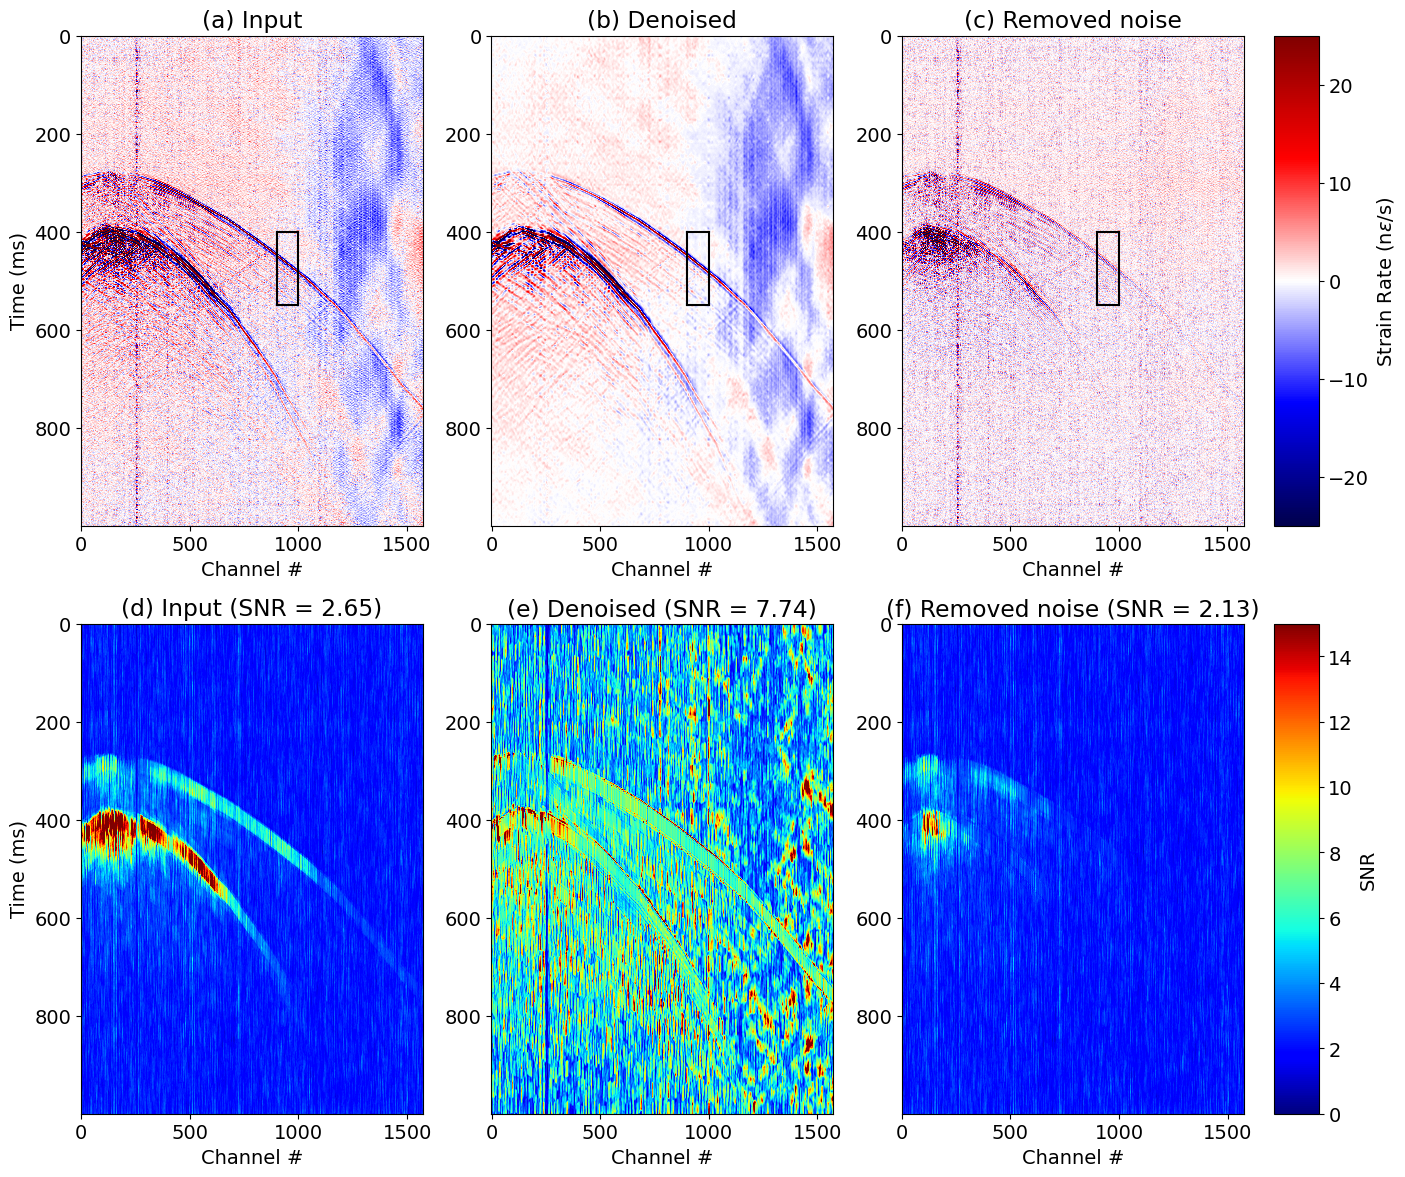

In [34]:
if plt_fig_paper:
    fig, axs = plt.subplots(2,3,figsize=(15,14))
    v_max = 25
    c_map = 'seismic'
    #--1st row: gathers
    axs[0,0].imshow(D[t_start_display:t_end_display,ch_start_display:ch_end_display], interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                    vmin=-v_max, vmax=v_max)
    axs[0,0].set(title='(a) Input', xlabel='Channel #', ylabel='Time (ms)')
    axs[0,1].imshow(st_array_out[t_start_display:t_end_display,ch_start_display:ch_end_display], interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                 vmin=-v_max, vmax=v_max)
    axs[0,1].set(title='(b) Denoised', xlabel='Channel #')
    im = axs[0,2].imshow(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                         interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                         vmin=-v_max, vmax=v_max)
    axs[0,2].set(title='(c) Removed noise', xlabel='Channel #')
    # Add single colorbar to the right
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.53, 0.03, 0.35])
    fig.colorbar(im, cax=cbar_ax, label='Strain Rate (n$\epsilon$/s)')
    if plot_zoom:
        ch_start_zoom=900
        ch_end_zoom=1000
        t_start_zoom=2200
        t_end_zoom=2350
        for i in range(0,3):
            axs[0,i].plot([ch_start_zoom,ch_end_zoom],[t_start_zoom-t_start_display,t_start_zoom-t_start_display], 'k')
            axs[0,i].plot([ch_start_zoom,ch_end_zoom],[t_end_zoom-t_start_display,t_end_zoom-t_start_display], 'k')
            axs[0,i].plot([ch_start_zoom,ch_start_zoom],[t_start_zoom-t_start_display,t_end_zoom-t_start_display], 'k')
            axs[0,i].plot([ch_end_zoom,ch_end_zoom],[t_start_zoom-t_start_display,t_end_zoom-t_start_display], 'k')    
    #--2nd row: SNR sections
    v_snr = 15
    axs[1,0].imshow(snr_in, 
                    interpolation=interpolation_opt, aspect='auto', cmap='jet', vmin=0, vmax=v_snr)
    axs[1,0].set(title='(d) Input (SNR = {:.02f})'.format(snr_frame_in), xlabel='Channel #', ylabel='Time (ms)')
    pcm = axs[1,1].imshow(snr_out_N2N, 
                          interpolation=interpolation_opt, aspect='auto', cmap='jet', vmin=0, vmax=v_snr)
    axs[1,1].set(title='(e) Denoised (SNR = {:.02f})'.format(snr_frame_out_N2N), xlabel='Channel #')
    im2 = axs[1,2].imshow(snr_noise_N2N, 
                          interpolation=interpolation_opt, aspect='auto', cmap='jet', vmin=0, vmax=v_snr)
    axs[1,2].set(title='(f) Removed noise (SNR = {:.02f})'.format(snr_frame_noise_N2N), xlabel='Channel #')
    # Add single colorbar to the right
    fig.subplots_adjust(right=0.9)
    cbar_ax2 = fig.add_axes([0.92, 0.11, 0.03, 0.35])
    fig.colorbar(im2, cax=cbar_ax2, label='SNR')
    plt.show()  